In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch    
from sklearn.decomposition import PCA
import hydra

from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import *
from openretina.models.core_readout import load_core_readout_from_remote
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
from openretina.utils.file_utils import get_local_file_path

# Load model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_core_readout_from_remote(
    "hoefling_2024_base_low_res", device="cuda" if torch.cuda.is_available() else "cpu"
)
model

CoreReadout(
  (core): <super: <class 'Core'>, <SimpleCoreWrapper object>> [SimpleCoreWrapper regularizers: gamma_hidden = 0.0|gamma_in_sparse = 0.0|gamma_input = 0.0|gamma_temporal = 40.0]
  
  (readout): MultiGaussianReadoutWrapper(
    (session_1_ventral1_20200226): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 80)
    
    (session_1_ventral1_20200528): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 42)
    
    (session_1_ventral1_20200707): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 74)
    
    (session_1_ventral1_20201021): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 32)
    
    (session_1_ventral1_20201030): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 40)
    
    (session_1_ventral1_20210929): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 48)
    
    (session_1_ventral1_20210930): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 26)
    
    (session_1_ventral2_20200302): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 41)
    
    (session_1_ventral2_20200707): SimpleSpatialXFeature3d ( 16 x 8 x 6 -> 56)
    
    (sess

In [3]:
# pick a random session
session_id = list(model.readout.keys())[-1]
print(session_id)
n_neurons = model.readout[session_id].outdims
print(f"Number of neurons: {n_neurons}")

session_6_ventral2_20210921
Number of neurons: 41


# Load natural images

In [4]:
# For Hoefling et al, let's load training data
with hydra.initialize(config_path=os.path.join("..", "configs"), version_base="1.3"):
    cfg = hydra.compose(config_name="hoefling_2024_core_readout_low_res.yaml")

movies_path = get_local_file_path(file_path=cfg.paths.movies_path, cache_folder=cfg.paths.data_dir)

movies_dict = movies_from_pickle(movies_path)

(<matplotlib.image.AxesImage at 0x773ea2bf0830>, (2, 16200, 18, 16))

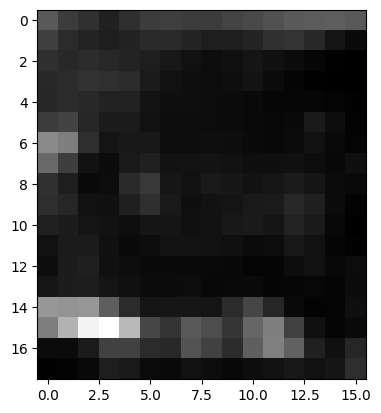

In [5]:
plt.imshow(movies_dict.train[0,2500], cmap='gray'), movies_dict.train.shape

In [6]:
n_images = 3000
rate = movies_dict.train.shape[1] // n_images
natural_images_library = movies_dict.train[:, ::rate, :, :].swapaxes(0, 1)

In [7]:
natural_images_library.shape

(3240, 2, 18, 16)

In [8]:
movies, n_empty_frames = prepare_movies_dataset(model, session_id,
    normalize_movies=False, # Already normalized
    image_library=natural_images_library, n_image_frames=60, device = device)
# 16 frames * 30 Hz = 0.53 seconds integration window

Model input shape: [2, 18, 16]
Using provided image library with shape: (3240, 2, 18, 16)
Image stats- Mean: -0.01, Std: 1.00, Min: -0.9178165417762062, Max: 6.2587746894023235
Number of empty frames needed: 30
Final movies shape: (3240, 2, 90, 18, 16)


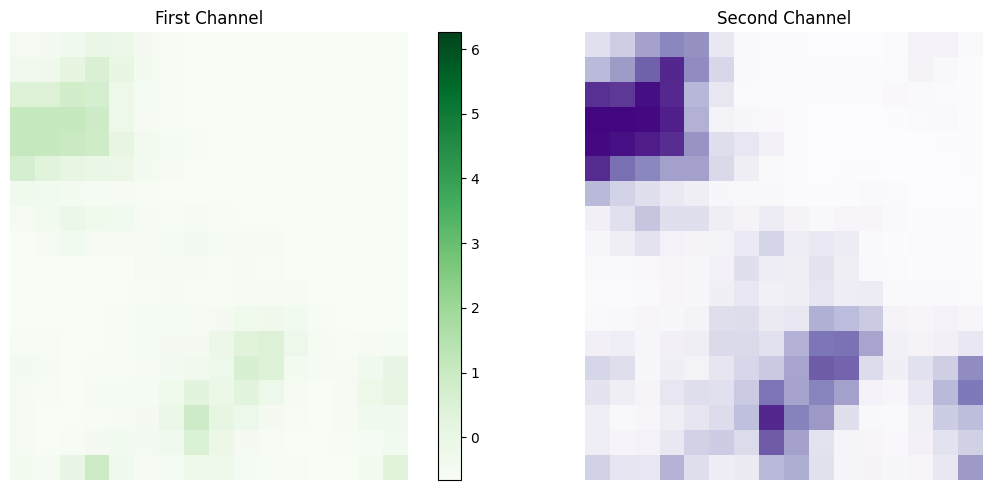

First channel range: [-0.659, 1.077]


In [9]:
# Display the last frame of an example movie with both channels side by side
example_idx = 135  # First movie as example
last_frame = movies[example_idx, :, -1] # movies[example_idx, :, -1]  # Shape: (2, 72, 64)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First channel (channel 0)
im1 = axes[0].imshow(last_frame[0], cmap='Greens', vmin=movies[:, 0].min(), vmax=movies[:, 0].max())
axes[0].set_title('First Channel')
plt.colorbar(im1, ax=axes[0])
axes[0].axis('off')
# Optional : Second channel (channel 1) 
im2 = axes[1].imshow(last_frame[1], cmap='Purples', vmin=movies[:, 1].min(), vmax=movies[:, 1].max())
axes[1].set_title('Second Channel')
# plt.colorbar(im2, ax=axes[1])
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"First channel range: [{last_frame[0].min():.3f}, {last_frame[0].max():.3f}]")
# print(f"Second channel range: [{last_frame[1].min():.3f}, {last_frame[1].max():.3f}]")

In [20]:
cell_id = 34  # LInear example | cell_id = 33 NONLINEAR Example
lsta_library, response_library = compute_lsta_library(
    model,
    movies[:n_images], # Can limit number of images for it to run faster
    session_id,
    cell_id,
    integration_window=(5, 5+35),  # Integration window for the LSTA
    batch_size=64,
    device=device,
)

In [21]:
lsta_library.shape, response_library.shape

((3000, 2, 18, 16), (3000, 70, 41))

Text(0, 0.5, 'Cell predicted Response (au)')

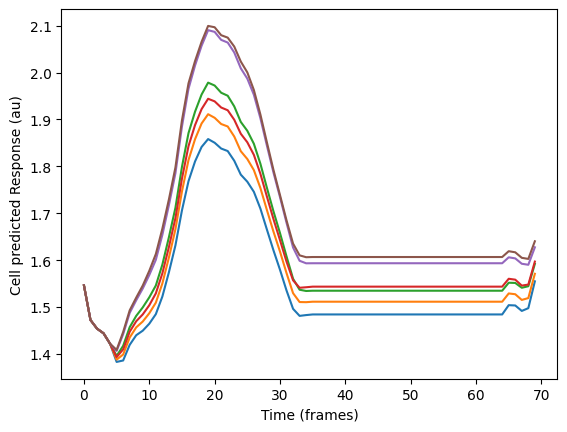

In [22]:
# We can check some sample responses, making sure the integrity of the response profile is predicted and we did not cut it too short.

plt.plot(response_library[0, :, cell_id])
plt.plot(response_library[1, :, cell_id])
plt.plot(response_library[2, :, cell_id])
plt.plot(response_library[3, :, cell_id])
plt.plot(response_library[4, :, cell_id])
plt.plot(response_library[5, :, cell_id])
plt.xlabel('Time (frames)')
plt.ylabel('Cell predicted Response (au)')

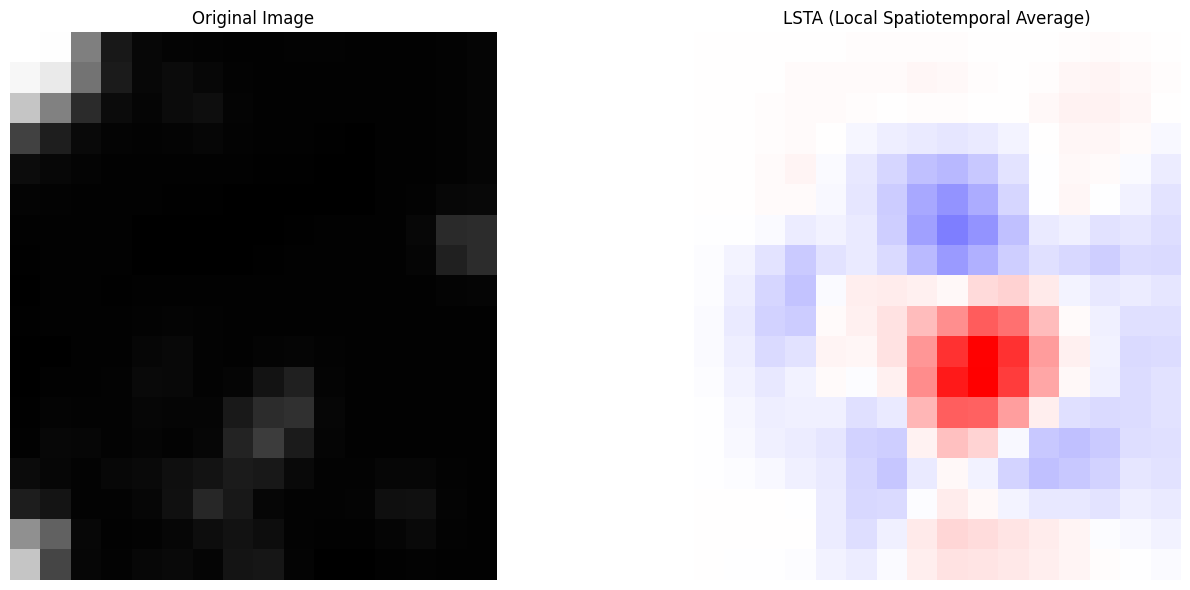

In [23]:
# We can now plot an example LSTA and the corresponding image

image = 0
channel = 0
lsta = lsta_library[image, channel]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# image
axes[0].imshow(movies[image,0,-1], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# LSTA
axes[1].imshow(lsta, cmap='bwr', vmin=-abs(lsta).max(), vmax=abs(lsta).max())
axes[1].set_title('LSTA (Local Spatiotemporal Average)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Do PCA on the LSTA library

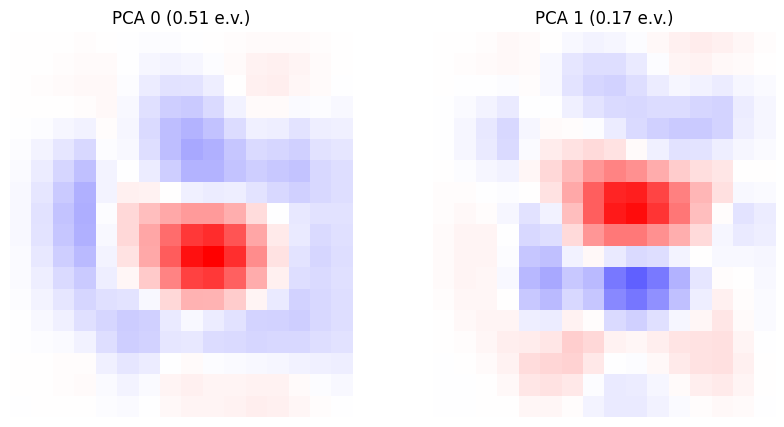

In [24]:
# Select channel
channel = 0
# lsta_library = lsta_library[:, :, :]

PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)

In [25]:
# Project the images onto PCA space
images = movies[:,channel,-1,:,:]
images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)

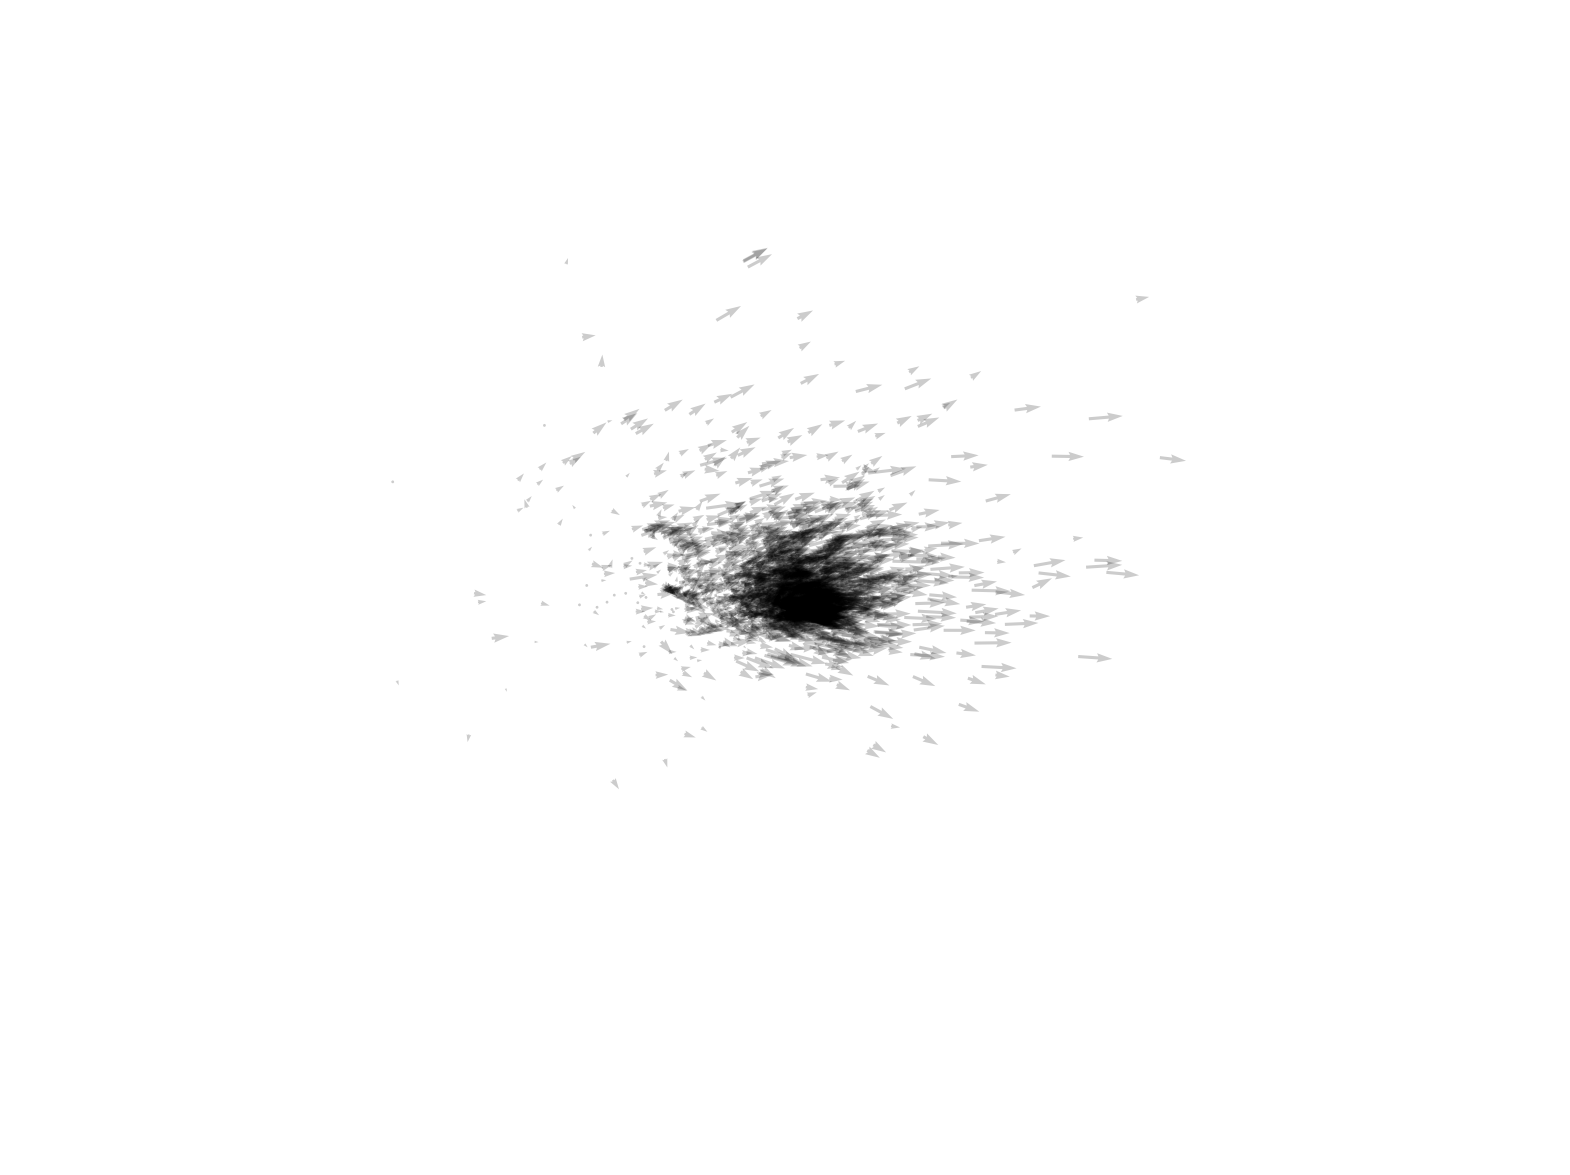

In [26]:
# Plot the vector field of the LSTA in PCA space
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_untreated_vectorfield

fig = plot_untreated_vectorfield(lsta_library[:, channel, :, :], PC1, PC2, images_coordinate)

/tmp/ipykernel_67869/949676331.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


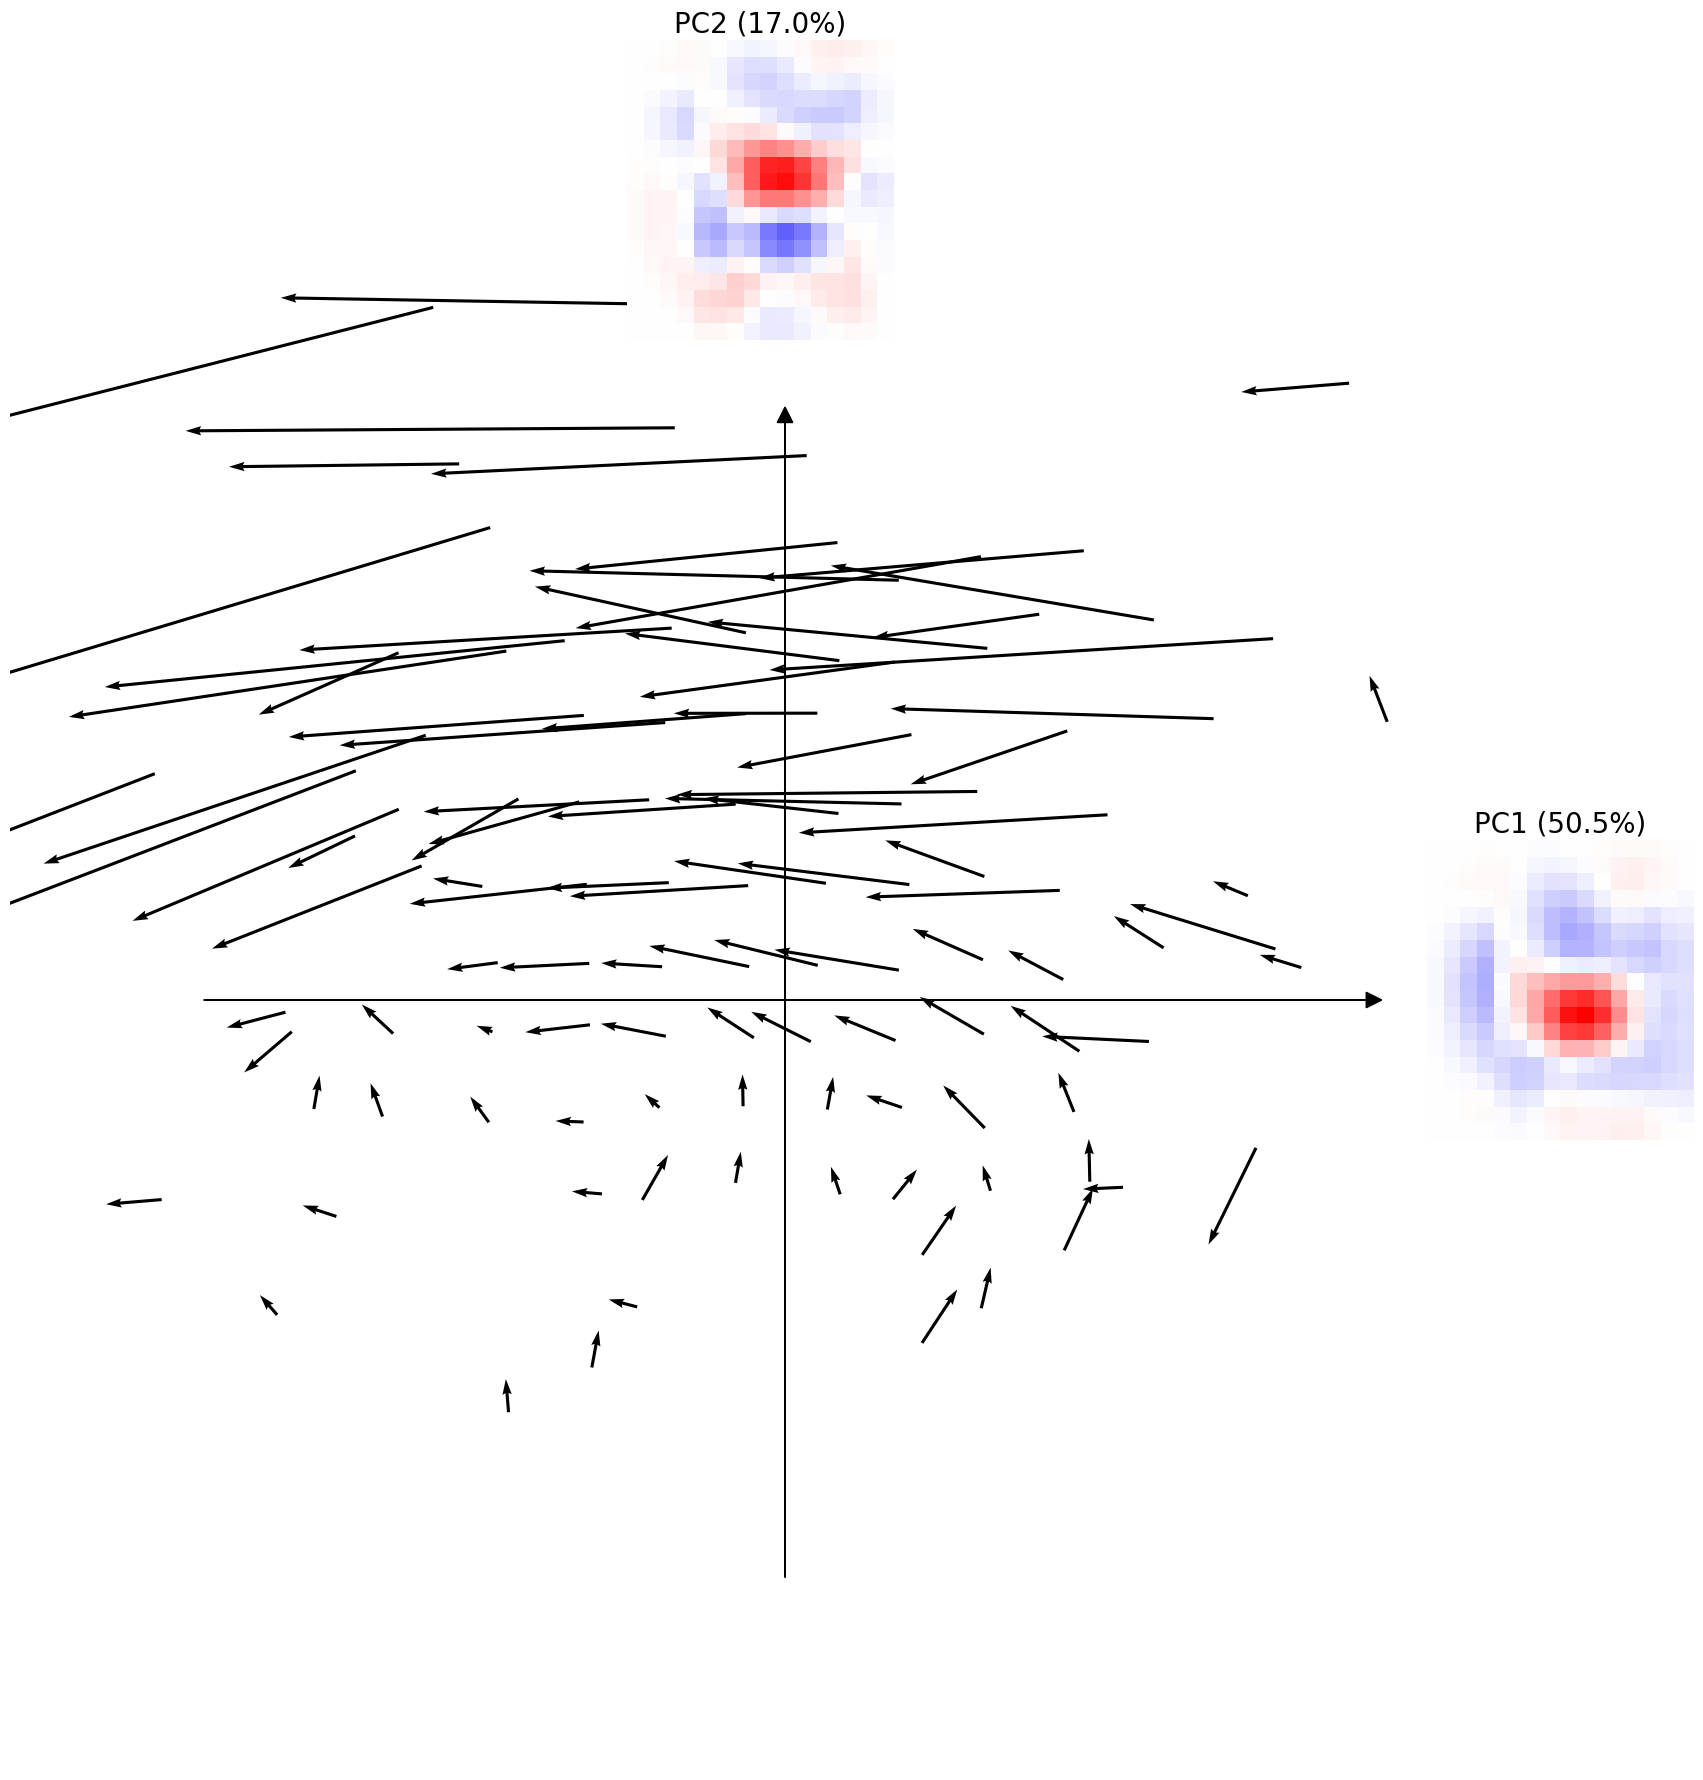

In [ ]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield
fig = plot_clean_vectorfield(
    lsta_library[:, channel, :, :],
    channel,
    PC1,
    PC2,
    images,
    images_coordinate,
    explained_variance,
    x_bins=30,
    y_bins=30,
)
fig.show()

# ADD the firing rate by the side + mention cell types

# Create all arrowplots of a session

In [28]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield


# for cell_id in range(n_neurons):
#     print(f"Processing cell {cell_id}...")
#     lsta_library, response_library = compute_lsta_library(model, movies, session_id, cell_id, batch_size=64, device=device)
#     PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)
#     images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)
#     fig = plot_clean_vectorfield(
#         lsta_library,
#         channel,
#         PC1,
#         PC2,
#         images,
#         images_coordinate,
#         explained_variance,
#         x_bins=31,
#         y_bins=31,
#     )
#     fig.savefig(f"karamanlis_vector_fields/cell_{cell_id}.png", dpi=300, bbox_inches='tight')
#     plt.close(fig)